In [11]:
%pip install -U pymoo

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.problems import get_problem
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
from scipy.stats import cauchy
from scipy.spatial.distance import cdist
from tabulate import tabulate
import copy
import warnings
from collections import deque

warnings.filterwarnings('ignore', category=UserWarning)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False

In [13]:
# Kích thước bộ nhớ cho L-SHADE
HISTORY_SIZE = 5

# Ngưỡng cho cơ chế injection
IGD_THRESHOLD = 0.05  # Ngưỡng IGD để kích hoạt injection
DIVERSITY_THRESHOLD = 0.15  # Ngưỡng độ đa dạng
INJECTION_COOLDOWN_PERCENT = 0.1  # Phần trăm thế hệ cho thời gian cooldown

# Tỷ lệ và tham số cho các toán tử
DE_PROBABILITY = 0.4  # Xác suất sử dụng DE mutation
NEIGHBORHOOD_RATIO = 0.15  # Tỷ lệ kích thước neighborhood
SBX_CROSSOVER_RATE = 0.9  # Tỷ lệ crossover cho SBX
POLY_MUTATION_RATE_DENOM = 1.0  # Mẫu số cho tính toán mutation rate
ETA_C = 20  # Chỉ số phân phối cho SBX
ETA_M = 20  # Chỉ số phân phối cho polynomial mutation

# Tham số cho OBL (Opposition-Based Learning)
OBL_JUMP_RATE_BASE = 0.1  # Tỷ lệ jump cơ bản cho OBL
OBL_NOISE_PROBABILITY = 0.3  # Xác suất thêm noise vào OBL
OBL_NOISE_SCALE = 0.05  # Tỷ lệ scale cho noise

# Tham số cho restart mechanism
RESTART_PATIENCE_RATIO = 0.125  # Tỷ lệ thế hệ cho restart patience (1/8)
POPULATION_KEEP_RATIO = 0.5  # Tỷ lệ giữ lại population khi restart

# Ngưỡng cho các phép toán số học
EPSILON = 1e-6  # Ngưỡng nhỏ cho so sánh số thực
EPSILON_DUPLICATES = 1e-6  # Ngưỡng phát hiện duplicates
EPSILON_IMPROVEMENT = 1e-6  # Ngưỡng cải thiện tối thiểu
INFINITY = float('inf')  # Giá trị vô cùng

# Tham số cho reference directions
REF_DIR_PARTITIONS = 12  # Số partitions cho reference directions

# Tham số cho DE mutation
F_LOWER_BOUND = 0.1  # Giới hạn dưới cho F
F_UPPER_BOUND = 1.0  # Giới hạn trên cho F
CR_LOWER_BOUND = 0.0  # Giới hạn dưới cho CR
CR_UPPER_BOUND = 1.0  # Giới hạn trên cho CR
DE_GLOBAL_PROB = 0.3  # Xác suất sử dụng DE toàn cục
DE_PBEST_RATIO = 0.2  # Tỷ lệ pBest cho DE local

# Tham số cho injection mechanism
INJECTION_SIZE_RATIO_DE = 0.1  # Tỷ lệ kích thước injection cho DE boost
INJECTION_SIZE_RATIO_OBL = 0.15  # Tỷ lệ kích thước injection cho OBL jump
MIN_INJECTION_SIZE = 5  # Kích thước injection tối thiểu cho DE
MIN_INJECTION_SIZE_OBL = 8  # Kích thước injection tối thiểu cho OBL

# Tham số cho covariance matrix
COV_MATRIX_UPDATE_WEIGHT_OLD = 0.7  # Trọng số cho covariance matrix cũ
COV_MATRIX_UPDATE_WEIGHT_NEW = 0.3  # Trọng số cho covariance matrix mới
COV_MATRIX_EPSILON = 1e-8  # Giá trị nhỏ để đảm bảo positive definiteness

# Tham số cho performance monitoring
PERFORMANCE_CHECK_INTERVAL = 3  # Khoảng thế hệ để kiểm tra performance
DIVERSITY_CHECK_INTERVAL = 8  # Khoảng thế hệ để kiểm tra độ đa dạng
STAGNATION_WINDOW_SIZE = 5  # Kích thước cửa sổ cho stagnation detection
RECENT_WINDOW_SIZE = 5  # Kích thước cửa sổ gần đây

# Tham số cho thí nghiệm
DEFAULT_POP_SIZE = 150  # Kích thước quần thể mặc định
DEFAULT_GENERATIONS = 300  # Số thế hệ mặc định

In [14]:
class ProblemWrapper:
    def __init__(self, p_prob):
        self.n_var = p_prob.n_var
        self.n_obj = p_prob.n_obj
        self.xl = p_prob.xl
        self.xu = p_prob.xu
        self.p_prob = p_prob

    def evaluate(self, x):
        return self.p_prob.evaluate(x)

class Individual:
    """Lớp biểu diễn một cá thể trong quần thể"""
    __slots__ = ['X', 'F', 'rank', 'crowding_dist', 'domination_count',
                 'dominated_set', 'creation_mode', 'used_F', 'used_CR']

    def __init__(self):
        self.X = None  # Biến quyết định
        self.F = None  # Giá trị hàm mục tiêu
        self.rank = None  # Thứ hạng non-dominated
        self.crowding_dist = 0.0  # Khoảng cách crowding
        self.domination_count = 0  # Số lượng cá thể dominate cá thể này
        self.dominated_set = []  # Tập các cá thể bị cá thể này dominate
        self.creation_mode = 'init'  # Phương thức tạo cá thể
        self.used_F = 0.5  # Giá trị F được sử dụng (cho DE)
        self.used_CR = 0.5  # Giá trị CR được sử dụng (cho DE)

In [15]:
def fast_non_dominated_sort_optimized(population):
    """Sắp xếp non-dominated tối ưu với vectorization"""
    n = len(population)
    if n == 0:
        return []

    F = np.array([ind.F for ind in population])

    # Tính toán domination sử dụng vectorization
    F_expanded_i = F[:, np.newaxis, :]  # (n, 1, m)
    F_expanded_j = F[np.newaxis, :, :]  # (1, n, m)

    # i dominates j nếu: tất cả F[i] <= F[j] VÀ có ít nhất 1 F[i] < F[j]
    less_equal = (F_expanded_i <= F_expanded_j).all(axis=2)
    strictly_less = (F_expanded_i < F_expanded_j).any(axis=2)
    dominates = less_equal & strictly_less

    # Đếm số lần bị dominated
    domination_count = dominates.sum(axis=0).copy()

    # Xây dựng các fronts
    fronts = []
    remaining_mask = np.ones(n, dtype=bool)
    rank = 1

    while remaining_mask.any():
        # Tìm các cá thể không bị dominated trong remaining
        current_front_mask = remaining_mask & (domination_count == 0)

        if not current_front_mask.any():
            break

        current_front_indices = np.where(current_front_mask)[0]
        current_front = []

        for idx in current_front_indices:
            population[idx].rank = rank
            current_front.append(population[idx])

        fronts.append(current_front)

        # Cập nhật domination count
        for idx in current_front_indices:
            dominated_by_idx = dominates[idx, :]
            domination_count[dominated_by_idx] -= 1

        # Loại bỏ current front khỏi remaining
        remaining_mask[current_front_indices] = False
        rank += 1

    return fronts

def calculate_crowding_distance_optimized(front):
    """Tính crowding distance tối ưu với NumPy vectorization"""
    l = len(front)
    if l <= 2:
        for ind in front:
            ind.crowding_dist = INFINITY
        return

    F_matrix = np.array([ind.F for ind in front])
    m = F_matrix.shape[1]

    # Khởi tạo distances
    distances = np.zeros(l)

    for obj in range(m):
        # Sort theo objective
        sorted_idx = np.argsort(F_matrix[:, obj])

        # Biên có khoảng cách vô cùng
        distances[sorted_idx[0]] = INFINITY
        distances[sorted_idx[-1]] = INFINITY

        f_min = F_matrix[sorted_idx[0], obj]
        f_max = F_matrix[sorted_idx[-1], obj]

        if f_max - f_min < 1e-14:
            continue

        # Vectorized distance calculation cho các phần tử giữa
        if l > 2:
            middle_idx = sorted_idx[1:-1]
            prev_idx = sorted_idx[:-2]
            next_idx = sorted_idx[2:]

            distances[middle_idx] += (F_matrix[next_idx, obj] - F_matrix[prev_idx, obj]) / (f_max - f_min)

    # Gán lại cho individuals
    for i, ind in enumerate(front):
        ind.crowding_dist = distances[i]

In [16]:
class InjectionMonitor:
    """Cơ chế giám sát và điều chỉnh Injection-based Adaptation"""
    def __init__(self, n_gen, pop_size, n_obj):
        self.n_gen = n_gen
        self.pop_size = pop_size
        self.n_obj = n_obj

        # Injection thresholds
        self.igd_threshold = IGD_THRESHOLD
        self.diversity_threshold = DIVERSITY_THRESHOLD

        # Injection counters
        self.injection_count = 0
        self.last_injection_gen = 0
        self.injection_cooldown = max(PERFORMANCE_CHECK_INTERVAL,
                                      int(n_gen * INJECTION_COOLDOWN_PERCENT))

        # Performance tracking
        self.best_igd = INFINITY
        self.igd_history = []

    def evaluate_convergence_state(self, igd_value, population, gen):
        """Đánh giá trạng thái hội tụ và quyết định injection"""
        self.igd_history.append(igd_value)

        # Cập nhật best values
        if igd_value < self.best_igd:
            self.best_igd = igd_value

        # Kiểm tra điều kiện injection
        should_inject = False
        injection_type = None

        # Điều kiện 1: Stagnation detection (IGD không cải thiện)
        if len(self.igd_history) >= STAGNATION_WINDOW_SIZE:
            recent_avg = np.mean(self.igd_history[-RECENT_WINDOW_SIZE:])
            older_avg = np.mean(self.igd_history[-STAGNATION_WINDOW_SIZE:-RECENT_WINDOW_SIZE])
            recent_improvement = older_avg - recent_avg

            if recent_improvement < EPSILON_IMPROVEMENT and igd_value > self.igd_threshold:
                should_inject = True
                injection_type = 'de_boost'

        # Điều kiện 2: Diversity loss
        if gen % DIVERSITY_CHECK_INTERVAL == 0 and self.calculate_diversity(population) < self.diversity_threshold:
            should_inject = True
            injection_type = 'obl_jump'

        # Điều kiện 3: Cooldown check
        if gen - self.last_injection_gen < self.injection_cooldown:
            should_inject = False

        return should_inject, injection_type

    def calculate_diversity(self, population):
        """Tính độ đa dạng của quần thể"""
        if len(population) < 2:
            return 1.0

        # Lấy các cá thể rank 1
        rank1_pop = [ind for ind in population if ind.rank == 1]
        if len(rank1_pop) < 2:
            return 0.0

        # Tính spread đơn giản
        F_matrix = np.array([ind.F for ind in rank1_pop])
        f_min, f_max = np.min(F_matrix, axis=0), np.max(F_matrix, axis=0)
        f_range = f_max - f_min
        f_range[f_range < EPSILON] = 1.0

        # Tính độ spread normalized
        spread = np.mean(f_range / (np.abs(f_min) + EPSILON))
        return min(spread, 1.0)

    def record_injection(self, gen):
        """Ghi lại lần injection"""
        self.injection_count += 1
        self.last_injection_gen = gen

In [21]:
class NSGA2_Optimized:
    def __init__(self, problem, pop_size=DEFAULT_POP_SIZE, n_gen=DEFAULT_GENERATIONS):
        self.problem = problem
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.n_var = problem.n_var
        self.n_obj = problem.n_obj
        self.xl = problem.xl
        self.xu = problem.xu

        # Khởi tạo Injection Monitor
        self.injection_monitor = InjectionMonitor(n_gen, pop_size, self.n_obj)

        # L-SHADE parameters
        self.H = HISTORY_SIZE
        self.memory_F = deque([0.5] * self.H, maxlen=self.H)
        self.memory_CR = deque([0.5] * self.H, maxlen=self.H)
        self.memory_pos = 0

        self.prob_de = DE_PROBABILITY
        self.T_neighbors = max(MIN_INJECTION_SIZE, int(self.pop_size * NEIGHBORHOOD_RATIO))
        self.pc = SBX_CROSSOVER_RATE
        self.pm = POLY_MUTATION_RATE_DENOM / self.n_var
        self.eta_c = ETA_C
        self.eta_m = ETA_M

        # Reference directions cho R-NSGA-II
        self.ref_dirs = generate_reference_directions(self.n_obj)

        # Covariance matrix adaptation cho mutation
        self.cov_matrix = np.eye(self.n_var) * 0.1

        self.population = []
        self.history = []
        self.injection_history = []  # Theo dõi các lần injection

    def initialize_population_obl(self):
        """Khởi tạo quần thể với OBL"""
        X_rand = self.xl + np.random.rand(self.pop_size, self.n_var) * (self.xu - self.xl)
        X_obl = self.xl + self.xu - X_rand
        X_all = np.vstack([X_rand, X_obl])
        X_all = np.clip(X_all, self.xl, self.xu)

        # Batch evaluation
        F_all = self.problem.evaluate(X_all)

        full_pop = []
        for i in range(len(X_all)):
            ind = Individual()
            ind.X = X_all[i].copy()
            ind.F = F_all[i].copy() if F_all.ndim > 1 else np.array([F_all[i]])
            full_pop.append(ind)

        fronts = fast_non_dominated_sort_optimized(full_pop)
        new_pop = []
        for front in fronts:
            calculate_crowding_distance_optimized(front)
            if len(new_pop) + len(front) <= self.pop_size:
                new_pop.extend(copy.deepcopy(front))
            else:
                front.sort(key=lambda x: x.crowding_dist, reverse=True)
                new_pop.extend(copy.deepcopy(front[:self.pop_size - len(new_pop)]))
                break
        return new_pop

    def check_duplicates_rank1_only(self, pop, epsilon=EPSILON_DUPLICATES):
        """Chỉ kiểm tra duplicates trên front rank 1"""
        rank1 = [ind for ind in pop if ind.rank == 1]
        others = [ind for ind in pop if ind.rank != 1]

        if len(rank1) < 2:
            return pop

        F_matrix = np.array([ind.F for ind in rank1])
        dists = cdist(F_matrix, F_matrix, metric='euclidean')
        keep_mask = np.ones(len(rank1), dtype=bool)

        for i in range(len(rank1)):
            if keep_mask[i]:
                keep_mask[i+1:][dists[i, i+1:] < epsilon] = False

        rank1_cleaned = [rank1[i] for i in range(len(rank1)) if keep_mask[i]]
        return rank1_cleaned + others

    def get_neighborhood_indices(self, population):
        """Tính neighborhood với cdist vectorization"""
        F_matrix = np.array([ind.F for ind in population])
        f_min, f_max = np.min(F_matrix, axis=0), np.max(F_matrix, axis=0)
        denom = f_max - f_min
        denom[denom == 0] = EPSILON
        F_norm = (F_matrix - f_min) / denom

        # cdist đã được tối ưu hóa cao bởi SciPy
        dists = cdist(F_norm, F_norm, metric='euclidean')
        return np.argpartition(dists, self.T_neighbors, axis=1)[:, 1:self.T_neighbors+1]

    def lshade_parameter_generation(self):
        """L-SHADE parameter generation"""
        # Chọn random index từ memory
        r = np.random.randint(0, len(self.memory_F))

        # Generate F từ Cauchy distribution với retry limit
        F = -1
        max_retries = 100
        retries = 0
        while (F <= F_LOWER_BOUND or F > F_UPPER_BOUND) and retries < max_retries:
            F = cauchy.rvs(loc=self.memory_F[r], scale=0.1)
            retries += 1

        # Fallback nếu không generate được
        if retries >= max_retries:
            F = np.clip(np.random.uniform(0.4, 0.9), F_LOWER_BOUND, F_UPPER_BOUND)
        else:
            F = np.clip(F, F_LOWER_BOUND, F_UPPER_BOUND)

        # Generate CR từ Normal distribution
        CR = np.random.normal(self.memory_CR[r], 0.1)
        CR = np.clip(CR, CR_LOWER_BOUND, CR_UPPER_BOUND)

        return F, CR

    def update_lshade_memory(self, success_F, success_CR):
        """Cập nhật L-SHADE memory với success-history-based adaptation"""
        if len(success_F) > 0:
            # Weighted Lehmer mean cho F
            weights = np.array(success_F) ** 2
            if weights.sum() > 0:
                mean_F = np.sum(weights * np.array(success_F)) / weights.sum()
            else:
                mean_F = np.mean(success_F)

            # Arithmetic mean cho CR
            mean_CR = np.mean(success_CR)

            # Cập nhật memory
            self.memory_F[self.memory_pos] = mean_F
            self.memory_CR[self.memory_pos] = mean_CR
            self.memory_pos = (self.memory_pos + 1) % self.H

    def smart_de_mutation_lshade(self, target_idx, population, neighbors_indices):
        """DE mutation với L-SHADE"""
        target = population[target_idx]
        use_global_de = np.random.rand() < DE_GLOBAL_PROB

        # L-SHADE parameter generation
        F_gen, CR_gen = self.lshade_parameter_generation()

        if use_global_de:
            r1, r2, r3 = random.sample(population, 3)
            v = r1.X + F_gen * (r2.X - r3.X)
        else:
            neighbors = [population[i] for i in neighbors_indices[target_idx]]
            neighbors.sort(key=lambda x: (x.rank or INFINITY, -x.crowding_dist))
            top_k = max(1, int(DE_PBEST_RATIO * len(neighbors)))
            x_pbest = random.choice(neighbors[:top_k])

            potential = [p for p in neighbors if not np.allclose(p.X, target.X)]
            pool = potential if len(potential) >= 2 else random.sample(population, min(2, len(population)))
            r1, r2 = random.sample(pool, min(2, len(pool)))

            v = target.X + F_gen * (x_pbest.X - target.X) + F_gen * (r1.X - r2.X)

        mask = np.random.rand(self.n_var) <= CR_gen
        if not np.any(mask):
            mask[np.random.randint(self.n_var)] = True
        u = np.where(mask, v, target.X)

        child = Individual()
        child.X = np.clip(u, self.xl, self.xu)
        child.creation_mode = 'de_global' if use_global_de else 'de_local'
        child.used_F = F_gen
        child.used_CR = CR_gen
        return child

    def generate_obl_offspring_adaptive(self, population, gen, jump_rate_base=OBL_JUMP_RATE_BASE):
        """OBL với adaptive jump rate"""
        # Adaptive jump rate
        if gen % DIVERSITY_CHECK_INTERVAL == 0 and gen > self.n_gen // 3:
            jump_rate = min(0.2, jump_rate_base * 1.5)
        else:
            jump_rate = jump_rate_base

        obl_pop = []
        X_mat = np.array([ind.X for ind in population])
        curr_min = np.min(X_mat, axis=0)
        curr_max = np.max(X_mat, axis=0)

        for ind in population:
            if np.random.rand() < jump_rate:
                ind_obl = Individual()
                if np.random.rand() < 0.5:
                    # Standard OBL
                    X_obl = self.xl + self.xu - ind.X
                else:
                    # Current population based OBL
                    X_obl = curr_min + curr_max - ind.X

                # Thêm Gaussian noise cho diversity
                if np.random.rand() < OBL_NOISE_PROBABILITY:
                    noise = np.random.normal(0, OBL_NOISE_SCALE * (self.xu - self.xl), self.n_var)
                    X_obl = X_obl + noise

                ind_obl.X = np.clip(X_obl, self.xl, self.xu)
                ind_obl.creation_mode = 'obl'
                obl_pop.append(ind_obl)

        return obl_pop

    def update_covariance_matrix(self, successful_offspring):
        """Cập nhật covariance matrix từ offspring thành công"""
        # Cần ít nhất n_var + 1 samples để tính covariance matrix
        if len(successful_offspring) > self.n_var:
            X_success = np.array([ind.X for ind in successful_offspring])
            try:
                new_cov = np.cov(X_success.T)
                # Đảm bảo matrix là positive definite
                if new_cov.shape == self.cov_matrix.shape:
                    self.cov_matrix = (COV_MATRIX_UPDATE_WEIGHT_OLD * self.cov_matrix +
                                     COV_MATRIX_UPDATE_WEIGHT_NEW * new_cov)
                    # Thêm small diagonal để ensure positive definiteness
                    self.cov_matrix += np.eye(self.n_var) * COV_MATRIX_EPSILON
            except:
                # Nếu có lỗi, giữ nguyên cov_matrix
                pass

    def sbx_crossover_mutation(self, p1, p2):
        """SBX crossover với polynomial mutation"""
        c = Individual()
        c.X = p1.X.copy()

        if np.random.rand() <= self.pc:
            diff_mask = np.abs(p1.X - p2.X) > EPSILON
            if np.any(diff_mask):
                idx = np.where(diff_mask)[0]
                y1, y2 = np.minimum(p1.X[idx], p2.X[idx]), np.maximum(p1.X[idx], p2.X[idx])
                yl, yu = self.xl[idx], self.xu[idx]

                rand = np.random.rand(len(idx))
                beta = 1 + 2 * (y1 - yl) / (y2 - y1)
                alpha = 2 - beta ** -(self.eta_c + 1)

                betaq = np.where(rand <= 1/alpha,
                               (rand * alpha) ** (1/(self.eta_c + 1)),
                               (1 / (2 - rand * alpha)) ** (1/(self.eta_c + 1)))

                c.X[idx] = 0.5 * ((y1 + y2) - betaq * (y2 - y1))
                c.X[idx] = np.clip(c.X[idx], yl, yu)

        mut_mask = np.random.rand(self.n_var) <= self.pm
        if np.any(mut_mask):
            idx = np.where(mut_mask)[0]
            y, yl, yu = c.X[idx], self.xl[idx], self.xu[idx]
            delta1 = (y - yl) / (yu - yl)
            delta2 = (yu - y) / (yu - yl)

            rand = np.random.rand(len(idx))
            mut_pow = 1 / (self.eta_m + 1)

            deltaq = np.zeros_like(y)
            mask_low = rand <= 0.5
            deltaq[mask_low] = (2*rand[mask_low] + (1-2*rand[mask_low]) * (1-delta1[mask_low])**(self.eta_m+1))**mut_pow - 1
            mask_high = ~mask_low
            deltaq[mask_high] = 1 - (2*(1-rand[mask_high]) + 2*(rand[mask_high]-0.5) * (1-delta2[mask_high])**(self.eta_m+1))**mut_pow

            c.X[idx] = np.clip(y + deltaq * (yu - yl), yl, yu)

        c.creation_mode = 'sbx'
        return c

    def tournament_selection(self, pop):
        """Tournament selection với reference directions"""
        p1, p2 = random.sample(pop, 2)

        # Xử lý trường hợp rank là None
        rank1 = p1.rank if p1.rank is not None else INFINITY
        rank2 = p2.rank if p2.rank is not None else INFINITY

        if rank1 != rank2:
            return p1 if rank1 < rank2 else p2

        # Nếu cùng rank, sử dụng reference-based diversity
        if rank1 == 1 and len(self.ref_dirs) > 0:
            # Vectorized distance calculation
            F_norm1 = p1.F / (np.linalg.norm(p1.F) + EPSILON)
            F_norm2 = p2.F / (np.linalg.norm(p2.F) + EPSILON)

            # Vectorized: tính tất cả distances cùng lúc
            dists1 = np.linalg.norm(self.ref_dirs - F_norm1, axis=1)
            dists2 = np.linalg.norm(self.ref_dirs - F_norm2, axis=1)

            dist1 = np.min(dists1)
            dist2 = np.min(dists2)

            # Ưu tiên cá thể gần reference direction hơn
            if abs(dist1 - dist2) > EPSILON:
                return p1 if dist1 < dist2 else p2

        return p1 if p1.crowding_dist > p2.crowding_dist else p2

    def apply_injection(self, injection_type, population, gen, igd_value):
        """Áp dụng injection strategy dựa trên loại injection"""

        print(f"  [INJECTION-{injection_type.upper()}] tại gen {gen}: IGD={igd_value:.6f}")
        self.injection_history.append((gen, injection_type, igd_value))

        injected_individuals = []

        if injection_type == 'de_boost':
            # Injection: DE-based exploration boost
            n_inject = max(MIN_INJECTION_SIZE, int(len(population) * INJECTION_SIZE_RATIO_DE))

            # Lấy các cá thể tốt nhất (rank 1)
            rank1_pop = [ind for ind in population if ind.rank == 1]
            if len(rank1_pop) == 0:
                rank1_pop = population[:min(10, len(population))]

            for i in range(n_inject):
                base_idx = np.random.randint(len(rank1_pop))
                base = rank1_pop[base_idx]

                # DE/current-to-best/1 with aggressive parameters
                F_aggressive = np.clip(np.random.uniform(0.8, 1.2), 0.5, 1.5)
                CR_aggressive = np.clip(np.random.uniform(0.7, 0.95), 0.5, 1.0)

                # Chọn donors từ rank 1
                if len(rank1_pop) >= 3:
                    donors = random.sample(rank1_pop, 3)
                    best_idx = np.argmin([np.linalg.norm(d.F) for d in donors])
                    x_best = donors[best_idx]
                    r1, r2 = donors[(best_idx+1)%3], donors[(best_idx+2)%3]
                else:
                    # Fallback to random selection
                    all_pop = population.copy()
                    random.shuffle(all_pop)
                    x_best, r1, r2 = all_pop[:3]

                # Mutation: current-to-best/1
                v = base.X + F_aggressive * (x_best.X - base.X) + F_aggressive * (r1.X - r2.X)

                # Crossover
                mask = np.random.rand(self.n_var) <= CR_aggressive
                if not np.any(mask):
                    mask[np.random.randint(self.n_var)] = True
                u = np.where(mask, v, base.X)

                child = Individual()
                child.X = np.clip(u, self.xl, self.xu)
                child.creation_mode = 'injection_de'
                child.used_F = F_aggressive
                child.used_CR = CR_aggressive
                injected_individuals.append(child)

        elif injection_type == 'obl_jump':
            # Injection: OBL-based diversity jump
            n_inject = max(MIN_INJECTION_SIZE_OBL, int(len(population) * INJECTION_SIZE_RATIO_OBL))

            # Lấy các cá thể đa dạng nhất (dựa trên crowding distance)
            sorted_pop = sorted(population, key=lambda x: x.crowding_dist if x.crowding_dist is not None else 0, reverse=True)
            diverse_pop = sorted_pop[:min(20, len(sorted_pop))]

            for i in range(n_inject):
                base = random.choice(diverse_pop)

                # OBL với extended bounds
                jitter = 0.2 * (self.xu - self.xl) * (np.random.rand(self.n_var) - 0.5)
                X_obl = self.xl + self.xu - base.X + jitter

                child = Individual()
                child.X = np.clip(X_obl, self.xl, self.xu)
                child.creation_mode = 'injection_obl'
                injected_individuals.append(child)

        # Batch evaluation cho injected individuals
        if injected_individuals:
            injected_X = np.array([ind.X for ind in injected_individuals])
            injected_F = self.problem.evaluate(injected_X)
            for i, ind in enumerate(injected_individuals):
                ind.F = injected_F[i].copy() if injected_F.ndim > 1 else np.array([injected_F[i]])

        return injected_individuals

    def run(self):
        """Chạy thuật toán single-population với Injection"""
        self.population = self.initialize_population_obl()
        fronts = fast_non_dominated_sort_optimized(self.population)
        for front in fronts:
            calculate_crowding_distance_optimized(front)

        stagnation_counter = 0
        restart_patience = max(20, int(self.n_gen * RESTART_PATIENCE_RATIO))
        last_best_ideal = np.min([ind.F for ind in self.population], axis=0)

        # Metrics tracking
        igd_history, hv_history = [], []
        igd_indicator, hv_indicator = None, None

        # Initialize performance indicators
        true_pf = None
        try:
            true_pf = self.problem.p_prob.pareto_front()
        except:
            pass

        for gen in range(self.n_gen):
            # ===== PERFORMANCE MONITORING =====
            # Tính IGD và HV mỗi 5 thế hệ hoặc khi cần injection
            F_current = np.array([ind.F for ind in self.population])

            if true_pf is not None and len(true_pf) > 0 and (gen % PERFORMANCE_CHECK_INTERVAL == 0 or gen == self.n_gen - 1):
                igd_indicator = IGD(true_pf)
                igd_value = igd_indicator(F_current)
                igd_history.append(igd_value)

                ref_point = np.max(true_pf, axis=0) * 1.1 + EPSILON
                hv_indicator = HV(ref_point=ref_point)
                hv_value = hv_indicator(F_current)
                hv_history.append(hv_value)

                # Kiểm tra điều kiện injection
                should_inject, injection_type = self.injection_monitor.evaluate_convergence_state(
                    igd_value, self.population, gen
                )

                if should_inject:
                    # Apply injection
                    injected_individuals = self.apply_injection(
                        injection_type, self.population, gen, igd_value
                    )

                    if injected_individuals:
                        # Thêm injected individuals vào quá trình selection
                        combined_pop = self.population + injected_individuals
                        self.injection_monitor.record_injection(gen)
                    else:
                        combined_pop = self.population
                else:
                    combined_pop = self.population
            else:
                combined_pop = self.population

            # ===== OFFSPRING GENERATION =====
            offspring = []
            neighbors_indices = self.get_neighborhood_indices(self.population)

            # Tạo offspring
            for i in range(self.pop_size):
                if np.random.rand() < self.prob_de:
                    child = self.smart_de_mutation_lshade(i, self.population, neighbors_indices)
                else:
                    p1 = self.tournament_selection(self.population)
                    p2 = self.tournament_selection(self.population)
                    child = self.sbx_crossover_mutation(p1, p2)
                offspring.append(child)

            # Adaptive OBL cho diversity boost
            obl_offspring = self.generate_obl_offspring_adaptive(self.population, gen, OBL_JUMP_RATE_BASE)
            offspring.extend(obl_offspring)

            # Batch evaluation
            if offspring:
                offspring_X = np.array([ind.X for ind in offspring])
                offspring_F = self.problem.evaluate(offspring_X)
                for i, ind in enumerate(offspring):
                    ind.F = offspring_F[i].copy() if offspring_F.ndim > 1 else np.array([offspring_F[i]])

            # Environmental selection
            combined_pop = combined_pop + offspring
            fronts = fast_non_dominated_sort_optimized(combined_pop)

            # Chỉ check duplicates trên rank 1
            combined_pop = self.check_duplicates_rank1_only(combined_pop)

            # Rebuild fronts sau khi loại duplicates
            fronts = fast_non_dominated_sort_optimized(combined_pop)

            new_pop = []
            for front in fronts:
                calculate_crowding_distance_optimized(front)
                if len(new_pop) + len(front) <= self.pop_size:
                    new_pop.extend(copy.deepcopy(front))
                else:
                    front.sort(key=lambda x: x.crowding_dist, reverse=True)
                    new_pop.extend(copy.deepcopy(front[:self.pop_size - len(new_pop)]))
                    break

            # Đảm bảo đủ pop_size
            while len(new_pop) < self.pop_size:
                ind = Individual()
                ind.X = self.xl + np.random.rand(self.n_var) * (self.xu - self.xl)
                ind.F = self.problem.evaluate(ind.X.reshape(1,-1))[0]
                new_pop.append(ind)

            self.population = new_pop[:self.pop_size]

            # L-SHADE memory update
            success_F = [ind.used_F for ind in offspring if hasattr(ind, 'rank') and ind.rank == 1 and ind.creation_mode.startswith('de')]
            success_CR = [ind.used_CR for ind in offspring if hasattr(ind, 'rank') and ind.rank == 1 and ind.creation_mode.startswith('de')]
            self.update_lshade_memory(success_F, success_CR)

            # Update covariance matrix
            successful_offspring = [ind for ind in offspring if hasattr(ind, 'rank') and ind.rank == 1]
            self.update_covariance_matrix(successful_offspring)

            self.history.append(np.array([ind.F for ind in self.population]))

            # Stagnation detection
            current_ideal = np.min([ind.F for ind in self.population], axis=0)
            if np.linalg.norm(current_ideal - last_best_ideal) < EPSILON:
                stagnation_counter += 1
            else:
                stagnation_counter = 0
                last_best_ideal = current_ideal

            # Restart mechanism
            if stagnation_counter >= restart_patience:
                # Giữ một phần population tốt nhất
                n_keep = int(self.pop_size * POPULATION_KEEP_RATIO)
                fronts = fast_non_dominated_sort_optimized(self.population)
                keep_pop = []
                for front in fronts:
                    calculate_crowding_distance_optimized(front)
                    if len(keep_pop) + len(front) <= n_keep:
                        keep_pop.extend(copy.deepcopy(front))
                    else:
                        front.sort(key=lambda x: x.crowding_dist, reverse=True)
                        keep_pop.extend(copy.deepcopy(front[:n_keep - len(keep_pop)]))
                        break

                # Tạo population mới với OBL
                n_new = self.pop_size - len(keep_pop)
                X_rand = self.xl + np.random.rand(n_new, self.n_var) * (self.xu - self.xl)
                X_obl = self.xl + self.xu - X_rand
                X_new = np.vstack([X_rand, X_obl])[:n_new]
                X_new = np.clip(X_new, self.xl, self.xu)

                F_new = self.problem.evaluate(X_new)
                for k in range(n_new):
                    ind = Individual()
                    ind.X = X_new[k].copy()
                    ind.F = F_new[k].copy() if F_new.ndim > 1 else np.array([F_new[k]])
                    keep_pop.append(ind)

                self.population = keep_pop[:self.pop_size]
                stagnation_counter = 0

                # Reset injection monitor sau khi restart
                self.injection_monitor.last_injection_gen = gen
                self.injection_monitor.best_igd = INFINITY
                self.injection_monitor.igd_history = []

        return np.array([ind.F for ind in self.population])

In [22]:
def run_experiment(problem_name, n_gen=DEFAULT_GENERATIONS, default_pop_size=DEFAULT_POP_SIZE, seed=1, n_var=None, n_obj=2):
    np.random.seed(seed)
    random.seed(seed)
    p_name_upper = problem_name.upper()
    print(f"BẮT ĐẦU CHẠY: {p_name_upper}")

    pymoo_prob = get_problem(problem_name, n_var=n_var)
    n_obj = pymoo_prob.n_obj

    print(f"• Cấu hình: Obj={n_obj} | Var={pymoo_prob.n_var} | Pop={default_pop_size} | Gen={n_gen}")

    solver = NSGA2_Optimized(
        ProblemWrapper(pymoo_prob),
        pop_size=default_pop_size,
        n_gen=n_gen
    )

    start_time = time.time()
    final_front = solver.run()
    end_time = time.time()
    run_time = end_time - start_time

    print(f"Thời gian chạy: {run_time:.4f} giây")

    true_pf = pymoo_prob.pareto_front()
    if true_pf is not None and len(true_pf) > 0:
        ref_point = np.max(true_pf, axis=0) * 1.1 + EPSILON
        igd_indicator = IGD(true_pf)
    else:
        ref_point = np.max(final_front, axis=0) * 1.1 + EPSILON
        igd_indicator = None

    hv_indicator = HV(ref_point=ref_point)

    igd_history, hv_history = [], []
    for gen_pop_F in solver.history:
        if igd_indicator is not None:
            try:
                igd_history.append(igd_indicator(gen_pop_F))
            except:
                igd_history.append(INFINITY)
        try:
            hv_history.append(hv_indicator(gen_pop_F))
        except:
            hv_history.append(0.0)

    final_igd = igd_history[-1] if igd_history else INFINITY
    final_hv = hv_history[-1] if hv_history else 0.0

    print(f"  >> IGD Final: {final_igd:.6f}")
    print(f"  >> HV  Final: {final_hv:.6f}")

    # Visualization
    fig = plt.figure(figsize=(18, 5))
    fig.suptitle(f'Result: {p_name_upper}', fontsize=16, fontweight='bold')

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(igd_history if igd_history else [INFINITY]*n_gen, color='#1f77b4', linewidth=2, label='IGD')
    ax1.set_title('IGD Convergence')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('IGD Value')
    ax1.ticklabel_format(style='plain', axis='y')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(hv_history, color='#2ca02c', linewidth=2, label='HV')
    ax2.set_title('HV Convergence')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('HV Value')
    ax2.ticklabel_format(style='plain', axis='y')


    ax3 = fig.add_subplot(1, 3, 3)
    if true_pf is not None:
        ax3.scatter(true_pf[:, 0], true_pf[:, 1], c='grey', alpha=0.3, s=15, label='True PF')
    ax3.scatter(final_front[:, 0], final_front[:, 1], c='#d62728', s=30, label='Found PF', edgecolors='black', linewidth=0.5)
    ax3.set_title('Pareto Front (2D)')
    ax3.legend()
    plt.tight_layout()
    plt.show()

    return {
        "Problem": p_name_upper,
        "n_Var": pymoo_prob.n_var,
        "n_Obj": n_obj,
        "IGD": final_igd,
        "HV": final_hv,
        "Time (s)": run_time,
    }

BẮT ĐẦU CHẠY: ZDT1
• Cấu hình: Obj=2 | Var=30 | Pop=150 | Gen=300


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Thời gian chạy: 21.6511 giây
  >> IGD Final: 0.002977
  >> HV  Final: 0.872827


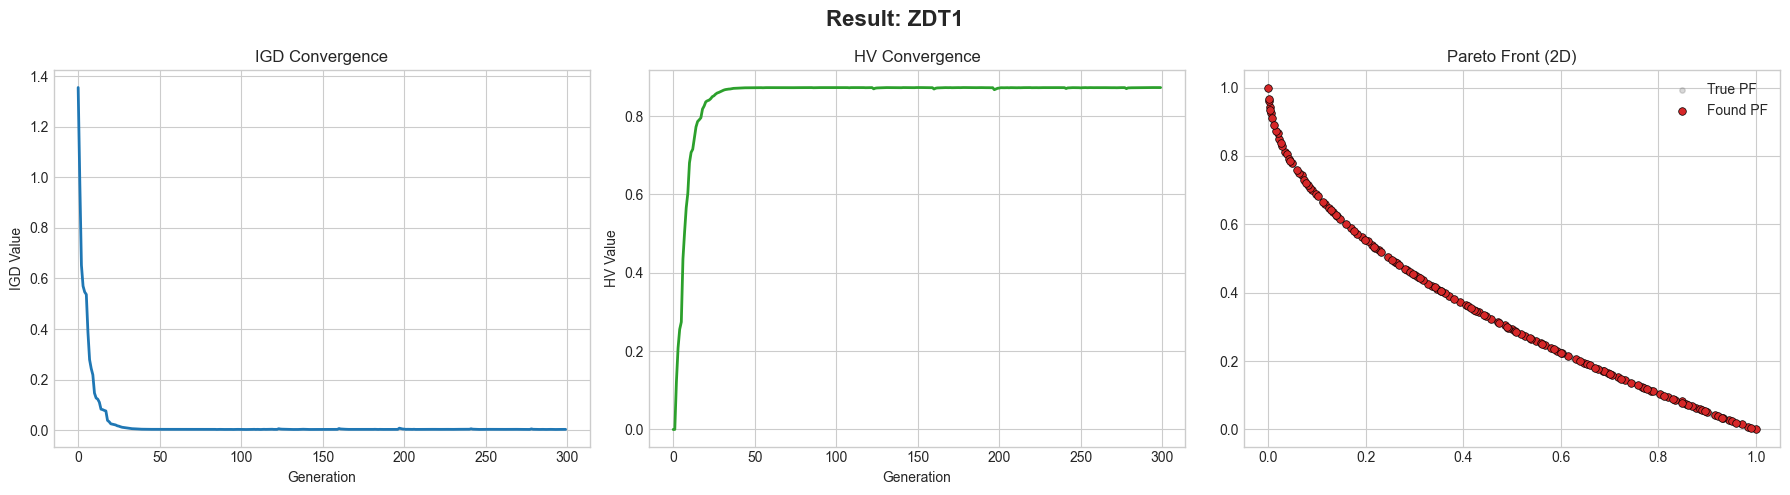

BẮT ĐẦU CHẠY: ZDT2
• Cấu hình: Obj=2 | Var=30 | Pop=150 | Gen=300
Thời gian chạy: 10.8611 giây
  >> IGD Final: 0.003599
  >> HV  Final: 0.539484


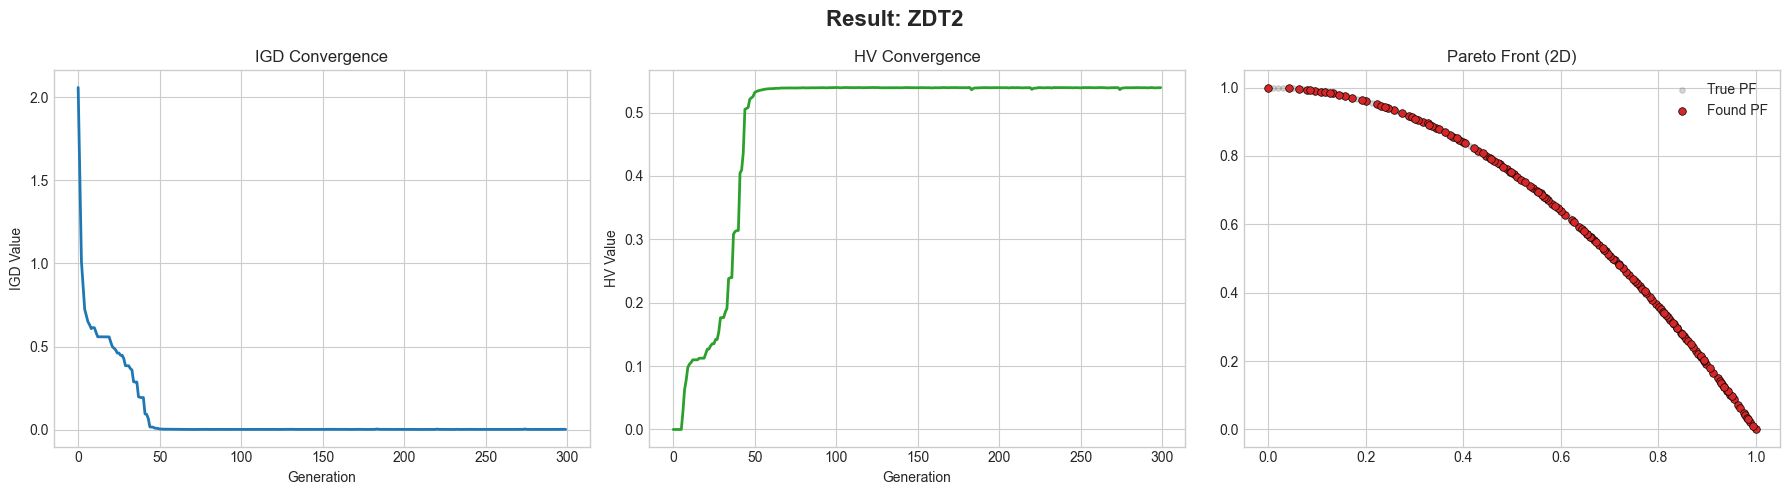

BẮT ĐẦU CHẠY: ZDT3
• Cấu hình: Obj=2 | Var=30 | Pop=150 | Gen=300
Thời gian chạy: 10.2492 giây
  >> IGD Final: 0.003860
  >> HV  Final: 1.024332


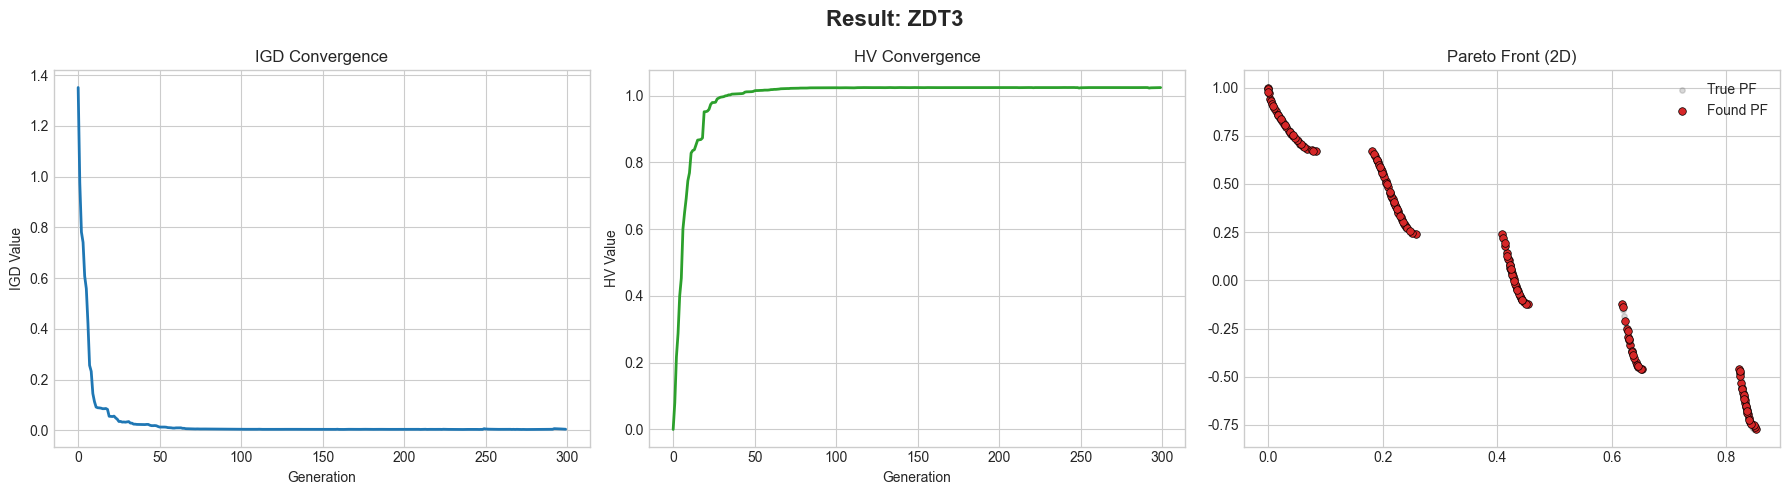

BẮT ĐẦU CHẠY: ZDT4
• Cấu hình: Obj=2 | Var=10 | Pop=150 | Gen=300
Thời gian chạy: 9.6257 giây
  >> IGD Final: 0.002984
  >> HV  Final: 0.872507


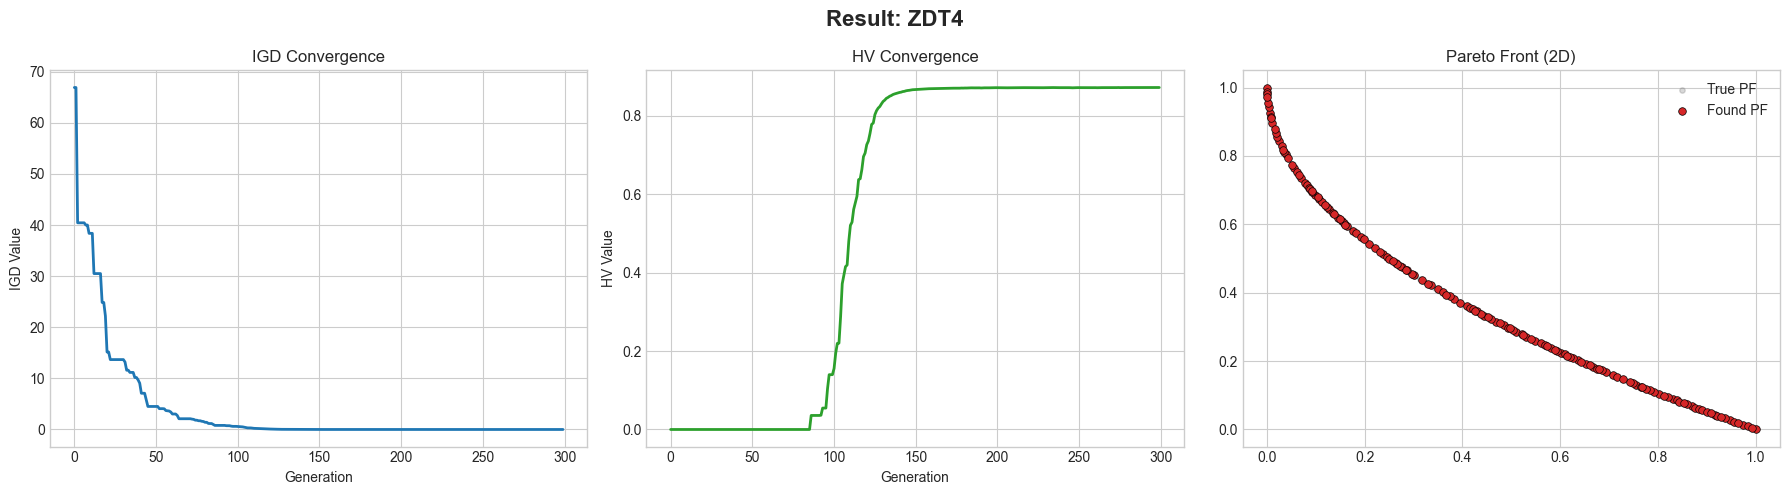

BẮT ĐẦU CHẠY: ZDT6
• Cấu hình: Obj=2 | Var=10 | Pop=150 | Gen=300
Thời gian chạy: 9.9131 giây
  >> IGD Final: 0.002525
  >> HV  Final: 0.434084


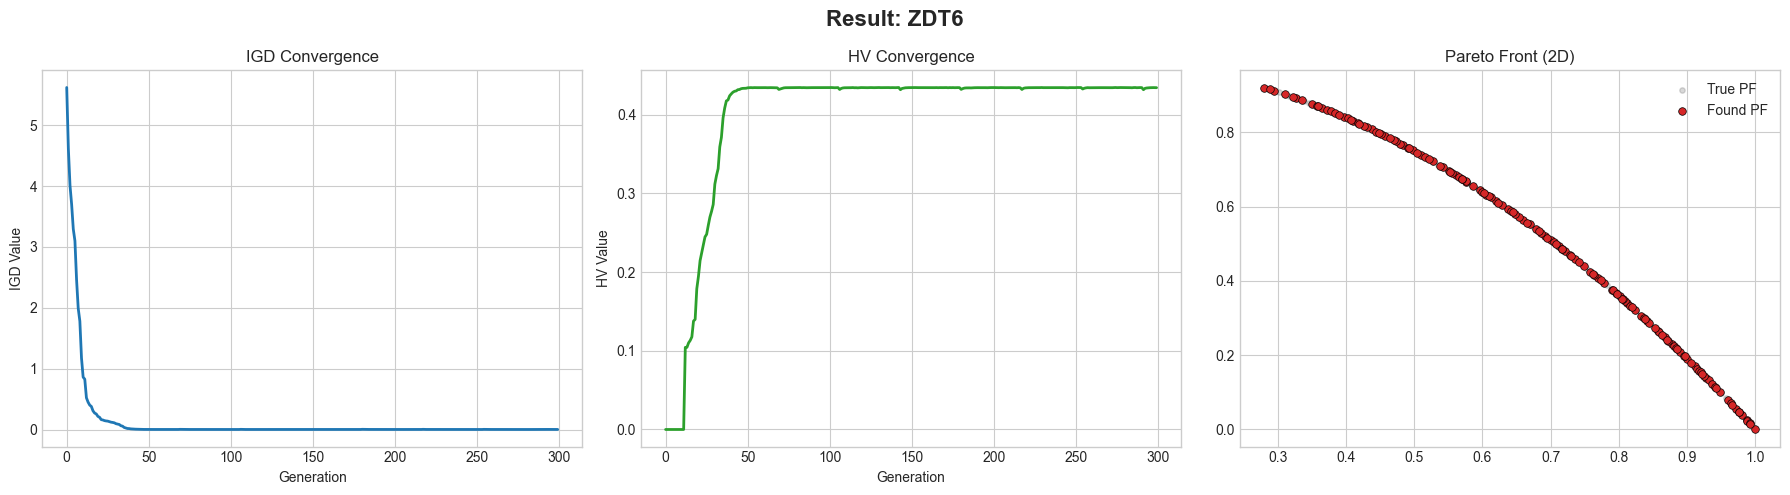

                             
KẾT QUẢ TỔNG HỢP ZDT                              
╒═══════════╤═════════╤═════════╤══════════╤══════════╤════════════╕
│ Problem   │   n_Var │   n_Obj │      IGD │       HV │   Time (s) │
╞═══════════╪═════════╪═════════╪══════════╪══════════╪════════════╡
│ ZDT1      │      30 │       2 │ 0.002977 │ 0.872827 │  21.651133 │
├───────────┼─────────┼─────────┼──────────┼──────────┼────────────┤
│ ZDT2      │      30 │       2 │ 0.003599 │ 0.539484 │  10.861141 │
├───────────┼─────────┼─────────┼──────────┼──────────┼────────────┤
│ ZDT3      │      30 │       2 │ 0.003860 │ 1.024332 │  10.249216 │
├───────────┼─────────┼─────────┼──────────┼──────────┼────────────┤
│ ZDT4      │      10 │       2 │ 0.002984 │ 0.872507 │   9.625705 │
├───────────┼─────────┼─────────┼──────────┼──────────┼────────────┤
│ ZDT6      │      10 │       2 │ 0.002525 │ 0.434084 │   9.913076 │
╘═══════════╧═════════╧═════════╧══════════╧══════════╧════════════╛


In [23]:
# Chạy với ZDT problems
POP_SIZE = DEFAULT_POP_SIZE
N_GEN = DEFAULT_GENERATIONS
problems_list = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6']
zdt_var_mapping = {'zdt1': 30, 'zdt2': 30, 'zdt3': 30, 'zdt4': 10, 'zdt6': 10}

results = []
for p_name in problems_list:
    n_var = zdt_var_mapping[p_name]
    res = run_experiment(p_name, n_gen=N_GEN, default_pop_size=POP_SIZE, n_var=n_var, seed=1)
    results.append(res)

df = pd.DataFrame(results)
print("\nKẾT QUẢ TỔNG HỢP ZDT".center(80))
print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".6f", showindex=False))


In [20]:
def generate_reference_directions(n_obj, n_partitions=REF_DIR_PARTITIONS):
    """Tạo reference directions cho R-NSGA-II"""
    if n_obj == 2:
        refs = np.linspace(0, 1, n_partitions + 1)
        directions = np.column_stack([refs, 1 - refs])
    else:
        # Simplified Das-Dennis cho 3+ objectives
        directions = []
        for i in range(n_partitions + 1):
            for j in range(n_partitions + 1 - i):
                k = n_partitions - i - j
                directions.append([i/n_partitions, j/n_partitions, k/n_partitions])
        directions = np.array(directions)

    # Normalize
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    norms[norms < EPSILON] = 1.0
    return directions / norms

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions


def evaluate_population_metrics(F, true_pf):
    if true_pf is not None and len(true_pf) > 0:
        ref_point = np.max(true_pf, axis=0) * 1.1 + EPS
        igd = IGD(true_pf)(F)
        hv = HV(ref_point=ref_point)(F)
    else:
        igd = float("inf")
        hv = 0.0
    return igd, hv


def run_nsga2_optimized_10_runs(problem_name, n_var, pop_size, n_gen):
    igd_list, hv_list = [], []

    for seed in range(1, 11):
        print(f"[Optimized NSGA-II] Run {seed}/10")
        np.random.seed(seed)
        random.seed(seed)

        prob = get_problem(problem_name, n_var=n_var)
        solver = NSGA2_Optimized(
            ProblemWrapper(prob),
            pop_size=pop_size,
            n_gen=n_gen
        )

        F = solver.run()
        true_pf = prob.pareto_front()
        igd, hv = evaluate_population_metrics(F, true_pf)

        print(f"   IGD={igd:.6f}, HV={hv:.6f}")

        igd_list.append(igd)
        hv_list.append(hv)

    return np.mean(igd_list), np.mean(hv_list)


def run_pymoo_algo_10_runs(algo_name, problem_name, n_var, pop_size, n_gen):
    igd_list, hv_list = [], []

    for seed in range(1, 11):
        print(f"[{algo_name}] Run {seed}/10")

        prob = get_problem(problem_name, n_var=n_var)
        true_pf = prob.pareto_front()

        # ===== FIX R-NSGA-II =====
        if algo_name == "NSGA-II":
            algo = NSGA2(pop_size=pop_size)

        elif algo_name == "R-NSGA-II":
            ref_dirs = get_reference_directions(
                "das-dennis",
                prob.n_obj,
                n_partitions=12
            )
            algo = RNSGA2(
                ref_points=ref_dirs,
                pop_size=pop_size
            )

        elif algo_name == "D-NSGA-II":
            algo = DNSGA2(pop_size=pop_size)

        else:
            raise ValueError("Unknown algorithm")

        res = minimize(
            prob,
            algo,
            termination=get_termination("n_gen", n_gen),
            seed=seed,
            verbose=False
        )

        F = res.F
        igd, hv = evaluate_population_metrics(F, true_pf)

        print(f"   IGD={igd:.6f}, HV={hv:.6f}")

        igd_list.append(igd)
        hv_list.append(hv)

    return np.mean(igd_list), np.mean(hv_list)


def full_benchmark(problem_name, n_var, pop_size, n_gen):
    results = []

    print("\n" + "="*60)
    print(f"BENCHMARK PROBLEM: {problem_name.upper()}")
    print("="*60)

    igd, hv = run_nsga2_optimized_10_runs(
        problem_name, n_var, pop_size, n_gen
    )
    results.append(["NSGA-II Optimized (Proposed)", igd, hv])

    igd, hv = run_pymoo_algo_10_runs(
        "NSGA-II", problem_name, n_var, pop_size, n_gen
    )
    results.append(["NSGA-II (pymoo)", igd, hv])

    igd, hv = run_pymoo_algo_10_runs(
        "R-NSGA-II", problem_name, n_var, pop_size, n_gen
    )
    results.append(["R-NSGA-II (pymoo)", igd, hv])

    igd, hv = run_pymoo_algo_10_runs(
        "D-NSGA-II", problem_name, n_var, pop_size, n_gen
    )
    results.append(["D-NSGA-II (pymoo)", igd, hv])

    df = pd.DataFrame(
        results,
        columns=["Algorithm", "IGD (mean of 10)", "HV (mean of 10)"]
    )

    print("\nKẾT QUẢ TỔNG HỢP".center(60))
    print(tabulate(df, headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))

    return df

In [ ]:
full_benchmark(
    problem_name="zdt1",
    n_var=30,
    pop_size=150,
    n_gen=300
)

In [ ]:
full_benchmark(
    problem_name="zdt2",
    n_var=30,
    pop_size=150,
    n_gen=300
)

In [ ]:
full_benchmark(
    problem_name="zdt3",
    n_var=30,
    pop_size=150,
    n_gen=300
)

In [ ]:
full_benchmark(
    problem_name="zdt4",
    n_var=10,
    pop_size=150,
    n_gen=300
)

In [ ]:
full_benchmark(
    problem_name="zdt6",
    n_var=10,
    pop_size=150,
    n_gen=300
)